In [157]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# import hyperas
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.data import Dataset

import tensorflow as tf

import statsmodels.api as sm

from hyperas import optim
from hyperopt import Trials, tpe

import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics, VAR, SARIMAX
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA



from hyperas import optim
from hyperas.distributions import choice, uniform
from hyperopt import STATUS_OK

In [2]:
df = pd.read_csv("model_data.csv")
df.drop(["Unnamed: 0"], axis=1, inplace=True)
df.set_index("Date", inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27140 entries, 1946-01-01 to 2020-10-08
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temp              27140 non-null  float64
 1   dewp              27140 non-null  float64
 2   slp               27140 non-null  float64
 3   visib             27140 non-null  float64
 4   wdsp              27140 non-null  float64
 5   max               27140 non-null  float64
 6   min               27140 non-null  float64
 7   fog               27140 non-null  float64
 8   rain_drizzle      27140 non-null  float64
 9   snow_ice_pellets  27140 non-null  float64
 10  hail              27140 non-null  float64
 11  thunder           27140 non-null  float64
 12  year sin          27140 non-null  float64
 13  year cos          27140 non-null  float64
dtypes: float64(14)
memory usage: 3.1+ MB


In [3]:
# df = df.diff(periods=180).dropna().reset_index().drop("index", axis=1)
# df

In [4]:
# Train, Validation, Test Split
train_df = df[0:int(len(df)*.7)]
val_df = df[int(len(df)*.7):int(len(df)*.9)]
test_df = df[int(len(df)*.9):]


In [5]:
scaler = StandardScaler()
scaler.fit(train_df)


StandardScaler()

In [6]:
train_scaled = scaler.transform(train_df)
val_scaled = scaler.transform(val_df)
test_scaled = scaler.transform(test_df)

In [7]:
# Various window parameters
input_width = 6
label_width = 6
shift = 1
label_columns = None

In [8]:
column_indeces = {name: i for i, name in enumerate(train_df.columns)}
if label_columns is not None:
    label_column_indeces = {name: i for i, name in enumerate(label_columns)}

window_size = input_width + shift

input_slice = slice(0, input_width)
input_indeces = np.arange(window_size)[input_slice]

label_start = window_size - label_width
label_slice = slice(label_start, None)
label_indeces =  np.arange(window_size)[label_slice]

In [9]:
def split_window(features):
    inputs = features[:, input_slice, :]
    labels = features[:, label_slice, :]
    if label_columns is not None:
        labels = tf.stack(
            [labels[:, :, column_indeces[name]] for name in label_columns], axis=1)

    inputs.set_shape([None, input_width, None])
    labels.set_shape([None, label_width, None])

    return inputs, labels

In [10]:
# Examples for testing
example_window = tf.stack([np.array(train_scaled[:window_size]),
                        np.array(train_scaled[100:100+window_size]),
                        np.array(train_scaled[200:200+window_size])])
example_inputs, example_labels = split_window(example_window)



In [11]:
def make_dataset(data):
    data = np.array(data, dtype=np.float32)
    dset = timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32
    )

    dset = dset.map(split_window)
    return dset

In [12]:
def compile_fit(model, train, val, patience=2, max_epochs=10, optimizer="adam"):
    e_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience, mode="min")

    model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=optimizer,
                    metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(train, epochs=max_epochs, validation_data = val, callbacks=[e_stop])
    return history

In [13]:
model_train = make_dataset(train_scaled)
model_val = make_dataset(val_scaled)
model_test = make_dataset(test_scaled)


In [14]:
def make_models(lstm_size, dense_size, dense_layer_num, activation, optimizer):

    model = Sequential()
    model.add(LSTM(lstm_size, return_sequences=True))
    for i in range(dense_layer_num):
        model.add(Dense(units=dense_size, activation=activation))
    model.add(Dense(14))

    e_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, mode="min")
    model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=optimizer,
                    metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(model_train, epochs=15, validation_data=model_val, callbacks=[e_stop])

    return {"loss": np.amin(history.history["val_loss"]), "status": STATUS_OK, "model":model}

In [15]:
histories = []
lstm_sizes = [16, 64]
dense_sizes = [50, 200]
dense_layers = [0, 1, 2]
activations = ["relu", "tanh"]
optimizers = ["adam"]
for lstm_size in lstm_sizes:
    for dense_size in dense_sizes:
        for dense_layer_num in dense_layers:
            for activation in activations:
                for optimizer in optimizers:
                    histories.append(make_models(lstm_size=lstm_size,
                                            dense_size=dense_size,
                                            dense_layer_num=dense_layer_num,
                                            activation=activation,
                                            optimizer=optimizer))
        

Epoch 1/15
594/594 [==============================] - 4s 6ms/step - loss: 0.6297 - mean_absolute_error: 0.5125 - val_loss: 0.3567 - val_mean_absolute_error: 0.3859
Epoch 2/15
594/594 [==============================] - 3s 5ms/step - loss: 0.4799 - mean_absolute_error: 0.3965 - val_loss: 0.3206 - val_mean_absolute_error: 0.3453
Epoch 3/15
594/594 [==============================] - 3s 6ms/step - loss: 0.4579 - mean_absolute_error: 0.3734 - val_loss: 0.3072 - val_mean_absolute_error: 0.3280
Epoch 4/15
594/594 [==============================] - 3s 5ms/step - loss: 0.4501 - mean_absolute_error: 0.3644 - val_loss: 0.3024 - val_mean_absolute_error: 0.3216
Epoch 5/15
594/594 [==============================] - 3s 5ms/step - loss: 0.4459 - mean_absolute_error: 0.3596 - val_loss: 0.2993 - val_mean_absolute_error: 0.3173
Epoch 6/15
594/594 [==============================] - 3s 5ms/step - loss: 0.4430 - mean_absolute_error: 0.3566 - val_loss: 0.2973 - val_mean_absolute_error: 0.3149
Epoch 7/15
594/5

KeyboardInterrupt: 

In [16]:
losses = []
for hist in histories:
    losses.append(hist["loss"])
losses

[0.2942143976688385]

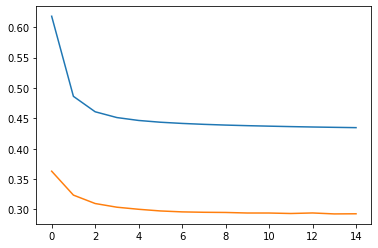

In [17]:
test_model = histories[0]["model"]
plt.plot(test_model.history.history["loss"], label="train")
plt.plot(test_model.history.history["val_loss"], label="test")
plt.show()

In [89]:
predictions_unscale = histories[0]["model"].predict(model_test)
predictions = scaler.inverse_transform(predictions_unscale)

In [18]:
pred_reshape = predictions.reshape((-1,14))

In [19]:
output_df = pd.DataFrame(predictions[:,5,:], columns=df.columns, index=test_df[6:].index)
output_df

temp       dewp          slp      visib      wdsp        max  \
Date                                                                            
2013-05-11  78.244972  63.925148  1005.484558  10.430911  9.449456  90.717537   
2013-05-12  67.755478  55.859276  1019.922974   9.759969  4.049412  80.726761   
2013-05-13  86.695061  74.580315  1014.757141  10.260888  4.613787  97.793678   
2013-05-14  75.877403  66.264481  1015.461182   9.574619  8.273528  85.386856   
2013-05-15  82.581512  74.569725  1016.033691   9.698111  5.725137  91.879677   
...               ...        ...          ...        ...       ...        ...   
2020-10-04  66.451050  57.060810  1018.009094   8.835138  7.231861  77.259514   
2020-10-05  63.641445  49.197762  1022.544250   9.781958  9.273241  74.745110   
2020-10-06  80.019836  71.234276  1018.575317   9.536396  5.714334  90.475555   
2020-10-07  74.892464  65.614037  1017.118408  10.103084  6.862671  84.077545   
2020-10-08  55.604046  35.986362  1022.973816  11.825698  6.387529  70.102608   

                  min       fog  rain_drizzle  snow_ice_pellets      hail  \
Date                                                                        
2013-05-11  67.174858  0.498413      0.111374          0.007970  0.002279   
2013-05-12  56.858311  0.215211      0.062181         -0.004537 -0.000663   
2013-05-13  77.388382  0.122003      0.153294          0.001213  0.000108   
2013-05-14  67.939049  0.297537      0.362203          0.003667  0.001301   
2013-05-15  76.033379  0.128320      0.445829         -0.000879 -0.000032   
...               ...       ...           ...               ...       ...   
2020-10-04  57.417114  0.381310      0.451613         -0.004935  0.001622   
2020-10-05  53.714119  0.146639      0.180172         -0.005170  0.001084   
2020-10-06  71.492706  0.244758      0.145720          0.004601 -0.000641   
2020-10-07  67.257469  0.153942      0.254066         -0.002471  0.000720   
2020-10-08  43.557961  0.025906      0.081789         -0.007178  0.000338   

             thunder  year sin  year cos  
Date                                      
2013-05-11  0.001089 -0.965860  0.446374  
2013-05-12  0.019715  0.898342 -0.416001  
2013-05-13  0.225534  0.484410  0.876904  
2013-05-14  0.172763 -0.749957  0.664554  
2013-05-15  0.353330  0.893508  0.400329  
...              ...       ...       ...  
2020-10-04  0.231863 -0.876553  0.349053  
2020-10-05  0.007851 -0.882907  0.470027  
2020-10-06  0.093092  0.979767  0.187360  
2020-10-07  0.112874 -0.818247  0.571126  
2020-10-08  0.020402 -0.663503 -0.377421  

[2708 rows x 14 columns]

In [32]:
resid = output_df["temp"] - test_df[6:]["temp"]
resid

Date
2013-05-11     5.004972
2013-05-12    -5.424522
2013-05-13    16.935061
2013-05-14     5.857403
2013-05-15    10.621512
                ...    
2020-10-04    -5.388950
2020-10-05    -9.718555
2020-10-06     7.239836
2020-10-07     2.092464
2020-10-08   -20.735954
Name: temp, Length: 2708, dtype: float64

In [177]:
resid_df = output_df - test_df[6:]
resid_df.drop(["year sin", "year cos"], axis=1, inplace=True)
resid_df

temp       dewp        slp     visib      wdsp        max  \
Date                                                                         
2013-05-11   5.004972  -0.934852 -10.195442  1.250911  4.309456   5.157537   
2013-05-12  -5.424522  -0.160724   0.082974 -0.240031 -2.130588  -2.253239   
2013-05-13  16.935061  21.000315  -8.342859  0.280888  0.033787  16.373678   
2013-05-14   5.857403   6.444481  -7.138818  0.714619  3.253528   2.986856   
2013-05-15  10.621512   8.269725  -2.846309 -0.041889 -1.874863  11.059677   
...               ...        ...        ...       ...       ...        ...   
2020-10-04  -5.388950  -1.959190  -1.650906 -0.184862  4.571861  -9.760486   
2020-10-05  -9.718555 -11.822238   2.684250  0.361958  5.493241 -10.054890   
2020-10-06   7.239836  11.734276   1.015317  0.516396  1.854334   3.415555   
2020-10-07   2.092464   7.034037   0.678408  0.683084  3.122671  -4.142455   
2020-10-08 -20.735954 -31.593638   7.553816  2.225698  4.007529  -8.917392   

                  min       fog  rain_drizzle  snow_ice_pellets      hail  \
Date                                                                        
2013-05-11   3.094858  0.498413     -0.888626          0.007970  0.002279   
2013-05-12  -6.361689  0.215211      0.062181         -0.004537 -0.000663   
2013-05-13  21.968382  0.122003      0.153294          0.001213  0.000108   
2013-05-14  10.959049 -0.302463      0.362203          0.003667  0.001301   
2013-05-15  11.113379  0.128320     -0.554171         -0.000879 -0.000032   
...               ...       ...           ...               ...       ...   
2020-10-04  -0.582886  0.181310      0.451613         -0.004935  0.001622   
2020-10-05 -10.265881  0.146639      0.180172         -0.005170  0.001084   
2020-10-06   9.272706  0.244758      0.145720          0.004601 -0.000641   
2020-10-07   7.657469  0.153942      0.254066         -0.002471  0.000720   
2020-10-08 -30.642039  0.025906      0.081789         -0.007178  0.000338   

             thunder  
Date                  
2013-05-11 -0.998911  
2013-05-12  0.019715  
2013-05-13  0.225534  
2013-05-14  0.172763  
2013-05-15  0.353330  
...              ...  
2020-10-04  0.231863  
2020-10-05  0.007851  
2020-10-06  0.093092  
2020-10-07  0.112874  
2020-10-08  0.020402  

[2708 rows x 12 columns]

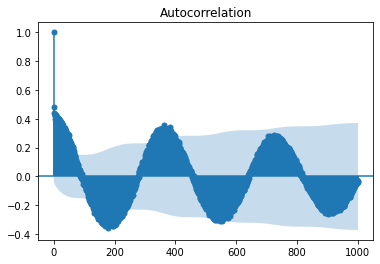

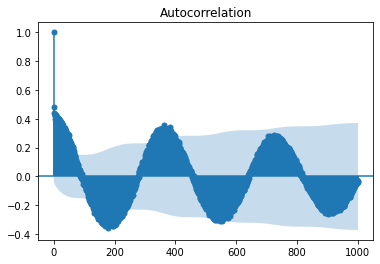

In [21]:
sm.graphics.tsa.plot_acf(resid, lags=1000)

In [91]:
resid_u = predictions_unscale[:,5,:1] - test_scaled[6:]["temp"]
resid_u

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [142]:
resid_u = pd.Series(predictions_unscale[:,5,:1].flatten(), index=pd.date_range("2013-05-11", periods=len(resid)), name="resid_u")
resid_u.freq = resid_u.index.inferred_freq
resid_u.describe()

count    2708.000000
mean        0.165668
std         0.919668
min        -3.079104
25%        -0.500169
50%         0.317336
75%         0.971892
max         1.555547
Name: resid_u, dtype: float64

In [33]:
sns.set_style('darkgrid')
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(16, 6))

In [72]:
resid = pd.Series(resid, index=pd.date_range("2013-05-11", periods=len(resid)), name="resid")
resid.freq = resid.index.inferred_freq
resid.describe()

count    2708.000000
mean       -0.421091
std        17.192563
min       -46.541903
25%       -12.258734
50%        -0.667650
75%        10.556462
max        55.745185
Name: resid, dtype: float64

In [122]:

sel = ar_select_order(resid_u, 13, glob=True, old_names=False, period=60)
res = sel.model.fit()
print(sel.ar_lags)
print(res.summary())

[]
                            AutoReg Model Results                             
Dep. Variable:                resid_u   No. Observations:                 2708
Model:                     AutoReg(0)   Log Likelihood               -3615.211
Method:               Conditional MLE   S.D. of innovations              0.919
Date:                Fri, 16 Oct 2020   AIC                             -0.166
Time:                        16:23:57   BIC                             -0.162
Sample:                    05-11-2013   HQIC                            -0.165
                         - 10-08-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1657      0.018      9.376      0.000       0.131       0.200


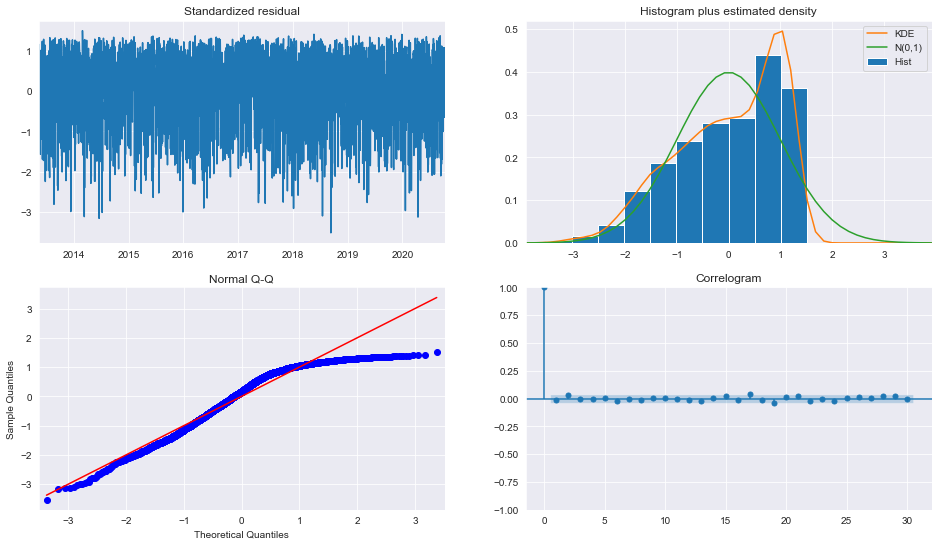

In [114]:
fig = plt.figure(figsize=(16, 9))
fig= res.plot_diagnostics(fig=fig, lags=30)

In [116]:
sel_s = ar_select_order(resid_u, 13, seasonal=True, old_names=False, period=60)
print(sel_s.ar_lags)
res_s = sel_s.model.fit()
print(res_s.summary())

[]
                            AutoReg Model Results                             
Dep. Variable:                resid_u   No. Observations:                 2708
Model:               Seas. AutoReg(0)   Log Likelihood               -3585.598
Method:               Conditional MLE   S.D. of innovations              0.909
Date:                Fri, 16 Oct 2020   AIC                             -0.145
Time:                        16:20:44   BIC                             -0.012
Sample:                    05-11-2013   HQIC                            -0.097
                         - 10-08-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0557      0.134     -0.415      0.678      -0.319       0.207
s(2,60)        0.1520      0.190      0.802      0.423      -0.220       0.524
s(3,60)        0.2803      0.190      1.478      

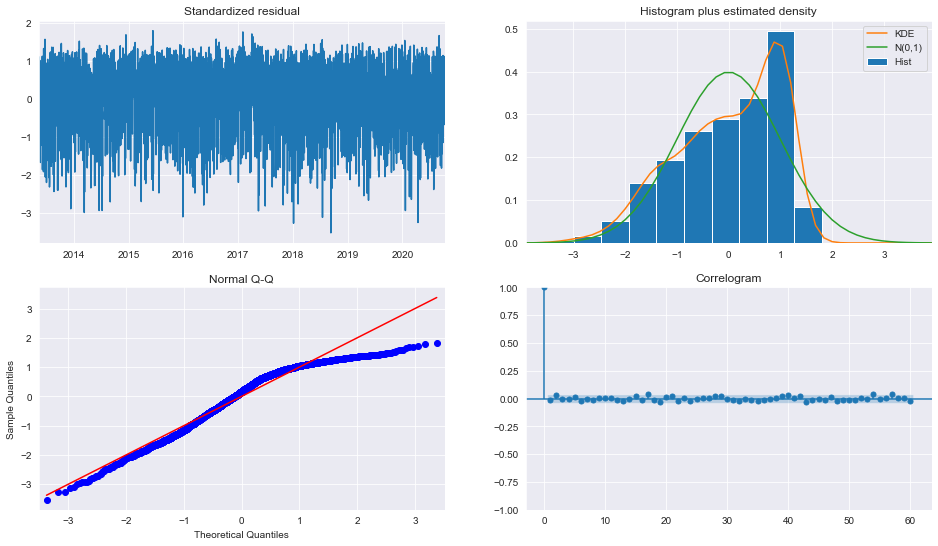

In [125]:
fig = plt.figure(figsize=(16, 9))
fig= res_s.plot_diagnostics(fig=fig, lags=60)

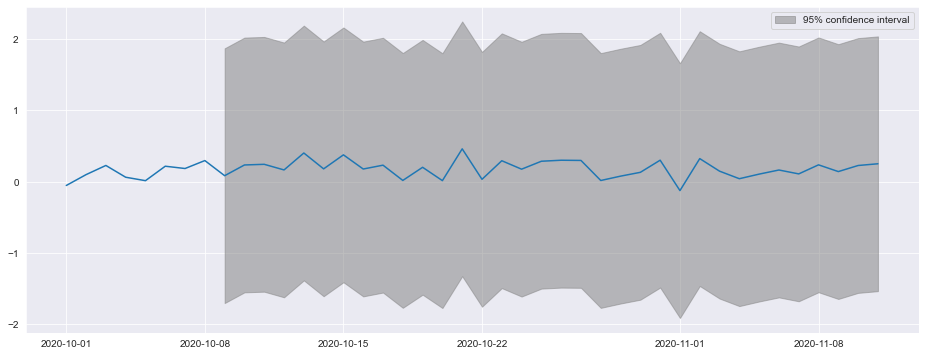

In [124]:
fig=res_s.plot_predict("2020-10-01", "2020-11-11")

In [74]:
resid_half = resid[:int(len(resid)/2)]
resid_half.describe()

count    1354.000000
mean        0.198033
std        17.576432
min       -46.541903
25%       -12.024487
50%        -0.393227
75%        11.939879
max        52.357163
Name: resid, dtype: float64

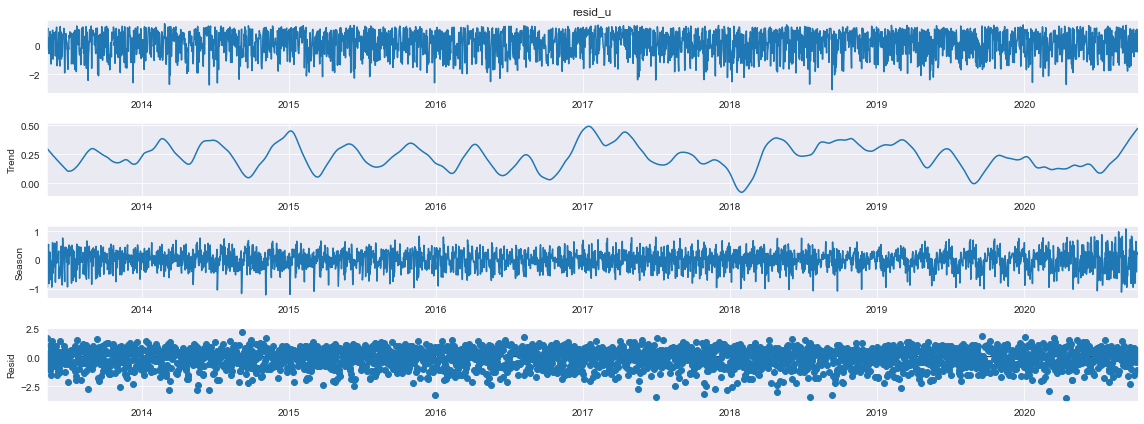

In [136]:

stl = STL(resid_u, seasonal=13, period=60, robust=True)
stl_res = stl.fit()
fig = stl_res.plot()

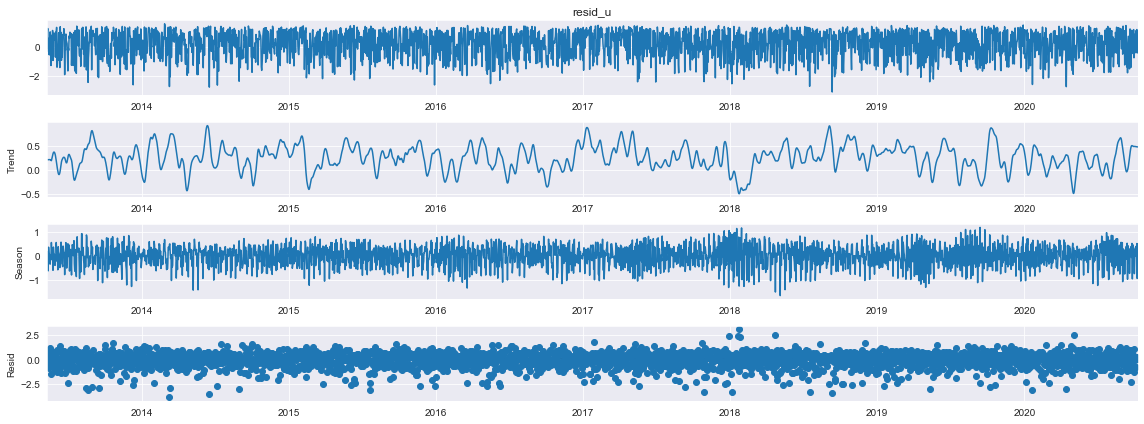

In [137]:
stl_loess = STL(resid_u, period=12, seasonal_deg=0, trend_deg=0, low_pass_deg=0, robust=True)
res_deg_0 = stl_loess.fit()
fig = res_deg_0.plot()

count    2708.000000
mean        0.165668
std         0.919668
min        -3.079104
25%        -0.500169
50%         0.317336
75%         0.971892
max         1.555547
Name: resid_u, dtype: float64

In [153]:

stlf = STLForecast(resid, ARIMA, model_kwargs=dict(order=(1, 1, 0), trend="c"))
stlf_res = stlf.fit()

forecast = stlf_res.forecast(24)
plt.plot(resid["2020-06-01":])
plt.plot(forecast)
plt.show()

TypeError: __init__() got an unexpected keyword argument 'seasonal'

In [180]:
var_mod = VAR(resid_df)
var_res = var_mod.fit(360)


D:\anaconda3\envs\weather\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [ ]:
print(var_res.summary())

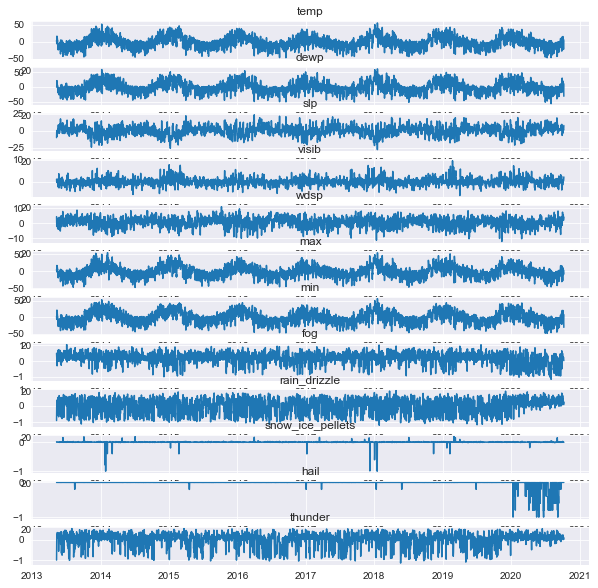

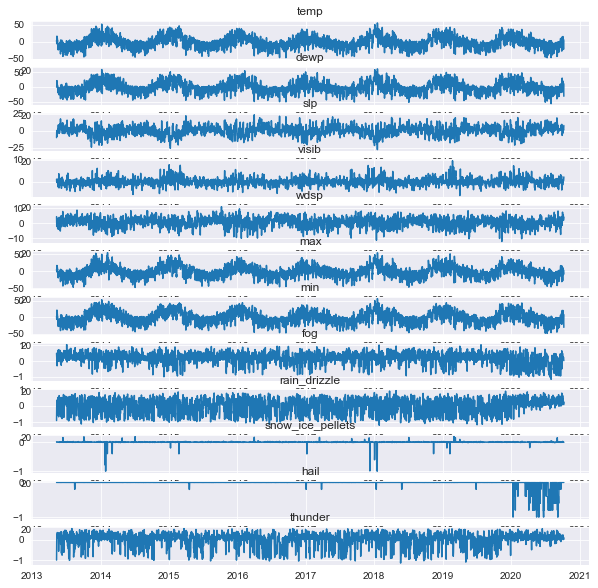

In [181]:
var_res.plot()

In [160]:
lag_order = var_res.k_ar
results.forecast()

KeyboardInterrupt: 